# Binary Classification with Sentence Transformers

## Requirements

In [ ]:
!pip install setfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer, TrainingArguments
import pandas as pd
from datasets import Dataset
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
import seaborn as sns

## Loading Dataset

In [ ]:
edus_dataset = pd.read_excel('Edus+Annotations Data.xlsx')
edus_dataset

,Annotated Text,Label,Anno_name_x,matches,Edu Speech,Anno_name_y,Appraisal?
0,wishes to express its satisfaction,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,Uruguay wishes to express its satisfaction for...,Uruguay wishes to express its satisfaction for...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
1,NaN,NaN,NaN,None,(2016).,UNSC_2016_SPV.7643_spch018_ann_Uruguay,no
2,we want to thank,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,"At the outset, we want to thank the United Sta...","At the outset, we want to thank the United Sta...",UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
3,is very pleased,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,Uruguay is very pleased to join the rest of th...,Uruguay is very pleased to join the rest of th...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
4,problem,appreciation-negative,UNSC_2016_SPV.7643_spch018_ann_Uruguay,that dealing with this problem can no longer b...,that dealing with this problem can no longer b...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
...,...,...,...,...,...,...,...
6445,NaN,NaN,NaN,None,Let us ensure,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,no
6446,criminal decree,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,that are currently enshrined in the criminal d...,that are currently enshrined in the criminal d...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes
6447,NaN,NaN,NaN,None,and let us stop that decree from being impleme...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,no
6448,extremely significant consequences,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,That would have extremely significant conseque...,That would have extremely significant conseque...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes


In [ ]:
# Selecting for data split
ratio = 0.90

total_rows = edus_dataset.shape[0]
train_size = int(total_rows*ratio)

In [ ]:
# Splitting data into test and train
train_data_df = edus_dataset[train_size:] # 10%
test_data_df =  edus_dataset[0:train_size] # 90%

In [ ]:
# Dropping speech name column
train_data_df = train_data_df.drop(['Anno_name_x', 'Anno_name_y'], axis=1)
test_data_df = test_data_df.drop(['Anno_name_x', 'Anno_name_y'], axis=1)

#Changing column names
train_data_df = train_data_df.rename(columns={'Edu Speech': 'text', 'Appraisal?': 'label'})
test_data_df = test_data_df.rename(columns={'Edu Speech': 'text', 'Appraisal?': 'label'})


In [ ]:
appraisal_labels = ['yes', 'no']
attitude_labels = ['affect-positive', 'affect-negative', 'judgement-positive', 'judgement-negative', 'appreciation-positive', 'appreciation-negative']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Getting attitude golden labels
gold_labels_appraisal= []
for i in range(test_data_df.shape[0]):
  gold_labels_appraisal.append(test_data_df.iloc[i]["label"])

In [ ]:
print(len(gold_labels_appraisal))

5805


In [ ]:
# Converting to train data format
training_data = Dataset.from_pandas(train_data_df)
training_data # rows= 645

Dataset({
    features: ['Annotated Text', 'Label', 'matches', 'text', 'label'],
    num_rows: 645
})

In [ ]:
# Converting to test data format
test_data = Dataset.from_pandas(test_data_df)
test_data # rows= 5805

Dataset({
    features: ['Annotated Text', 'Label', 'matches', 'text', 'label'],
    num_rows: 5805
})

## Loading Models for Binary Classification of Edus

### SetFit with BERT (paraphrase-mpnet-base-v2)

In [ ]:
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    batch_size=16,
    num_epochs=1,# Number of epochs to use for contrastive learning
)

In [ ]:
model.lables = attitude_labels

In [ ]:
# Creating the trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=training_data,
    eval_dataset=test_data,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1, # Number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"}
)

<ipython-input-36-7fcd7f67f837>:2: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/645 [00:00<?, ? examples/s]

KeyError: 'Field "label" exists 2 times in schema'

In [ ]:
# Training
trainer.train()

***** Running training *****
  Num unique pairs = 25800
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1613


Step,Training Loss


In [ ]:
metrics = trainer.evaluate()

***** Running evaluation *****


In [ ]:
trainer.evaluate(test_data)

Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'accuracy': 0.7481481481481481}

#### Label Predictions

In [ ]:
# Predicting labels for 87 annotated speeches fragments
predicted_Appraisal = model.predict(test_data_df['text'])

In [ ]:
 # Adding column with predicted labels to original test dataset
test_data_df['Appraisal Predicted Trans-sent-BERT']=pd.Series(predicted_Appraisal)

In [ ]:
# Saving file with predicted labels- Appraisal- with Bert
test_data_df.to_csv('Results predictions Appraisal Trans-sent-BERT.csv', index=False)

In [ ]:
test_data_df['Appraisal Predicted Trans-sent-BERT'].value_counts()

yes    3197
no     2608
Name: Appraisal Predicted Trans-sent-BERT, dtype: int64

In [ ]:
test_data_df

,Annotated Text,Label,matches,text,label,Appraisal Predicted Trans-sent-BERT
0,wishes to express its satisfaction,affect-positive,Uruguay wishes to express its satisfaction for...,Uruguay wishes to express its satisfaction for...,yes,yes
1,NaN,NaN,None,(2016).,no,no
2,we want to thank,affect-positive,"At the outset, we want to thank the United Sta...","At the outset, we want to thank the United Sta...",yes,yes
3,is very pleased,affect-positive,Uruguay is very pleased to join the rest of th...,Uruguay is very pleased to join the rest of th...,yes,yes
4,problem,appreciation-negative,that dealing with this problem can no longer b...,that dealing with this problem can no longer b...,yes,yes
...,...,...,...,...,...,...
5800,is not even the most radical group,judgement-negative,And that is not even the most radical group on...,And that is not even the most radical group on...,yes,yes
5801,peaceful political protects,appreciation-positive,Should we be surprised that the peaceful polit...,Should we be surprised that the peaceful polit...,yes,yes
5802,NaN,NaN,None,and the call by the people of south-eastern Uk...,no,no
5803,NaN,NaN,None,have been met by the Rada with draconic laws,no,yes


#### Evaluation

In [ ]:
# Predicted labels to list
predicted_Appraisal_list= test_data_df['Appraisal Predicted Trans-sent-BERT'].tolist()

In [ ]:
# Calculating accuracy- Not working check why
accuracy_attitude = accuracy_score(predicted_Appraisal_list, gold_labels_appraisal)
print("Accuracy score: {:.2f}".format(accuracy_attitude*100))

Accuracy score: 74.81


In [ ]:
# Classification Report - INTERPRET THIS RESULTS
# y_true, y_pred, labels= xxx
print(classification_report(gold_labels_appraisal, predicted_Appraisal_list, target_names=['yes','no']))

              precision    recall  f1-score   support

         yes       0.87      0.67      0.76      3386
          no       0.65      0.86      0.74      2419

    accuracy                           0.75      5805
   macro avg       0.76      0.76      0.75      5805
weighted avg       0.78      0.75      0.75      5805



In [ ]:
# Confusion Matrix
# y_true, y_pred, labels= xxx
confusion_matrix_Appraisal = confusion_matrix(gold_labels_appraisal, predicted_Appraisal_list, labels=['yes','no'])

In [ ]:
confusion_matrix_Appraisal

array([[2077,  342],
       [1120, 2266]])

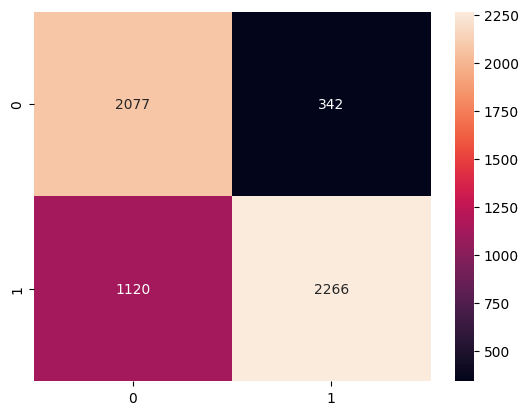

In [ ]:
# Conf Matrix
sns_matrix= sns.heatmap(confusion_matrix_Appraisal, annot= True, fmt='g')

In [ ]:
sns_matrix.figure.savefig("Conf_mat_App_Sent-Trans-BERT.png")

### SetFit with BART

In [ ]:
model_bart = SetFitModel.from_pretrained("tyzp-INC/few-shot-fb-bart-large-mnli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

In [ ]:
args = TrainingArguments(
    batch_size=16,
    num_epochs=5,# Number of epochs to use for contrastive learning
)

In [ ]:
model_bart.lables = ['yes', 'no']
#model_bart.lables = ['affect-positive', 'affect-negative', 'appreciation-positive', 'appreciation-negative', 'judgement-positive', 'judgement-negative']

In [ ]:
# Creating the trainer
trainer = SetFitTrainer(
    model=model_bart,
    train_dataset=training_data,
    eval_dataset=test_data,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=5, # Number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"}
)

<ipython-input-17-faff5e161006>:2: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/645 [00:00<?, ? examples/s]

In [ ]:
# Training
trainer.train()

***** Running training *****
  Num unique pairs = 25800
  Batch size = 16
  Num epochs = 5
  Total optimization steps = 8065


Step,Training Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau

Step,Training Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


In [ ]:
trainer.evaluate(test_data)

Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'accuracy': 0.765891472868217}

#### Prediction of Appraisal Labels

In [ ]:
# Predicting labels with BART-setfit
predicted_Appraisal_bart = model_bart.predict(test_data_df['text'])

In [ ]:
 # Adding column with predicted labels to original test dataset
test_data_df['SetFit-BART Appraisal Predicted']=pd.Series(predicted_Appraisal_bart)

In [ ]:
test_data_df['SetFit-BART Appraisal Predicted'].value_counts()

yes    3310
no     2495
Name: SetFit-BART Appraisal Predicted, dtype: int64

In [ ]:
test_data_df['label'].value_counts()

no     3386
yes    2419
Name: label, dtype: int64

In [ ]:
# Saving predictions
test_data_df.to_csv("SetFit-BART Attitude Results.csv")

#### Evaluation

In [ ]:
# Calculating accuracy-
accuracy_att_bart = accuracy_score(predicted_Appraisal_bart, gold_labels_appraisal)
print("Accuracy score: {:.2f}".format(accuracy_att_bart*100))

Accuracy score: 76.59


In [ ]:
# Classification Report - INTERPRET THIS RESULTS
# y_true, y_pred, labels= xxx
print(classification_report(gold_labels_appraisal, predicted_Appraisal_bart))

              precision    recall  f1-score   support

          no       0.91      0.67      0.77      3386
         yes       0.66      0.90      0.76      2419

    accuracy                           0.77      5805
   macro avg       0.78      0.79      0.77      5805
weighted avg       0.80      0.77      0.77      5805



In [ ]:
# Confusion Matrix
# y_true, y_pred, labels= xxx
confusion_matrix_Appraisal_Bart = confusion_matrix(gold_labels_appraisal, predicted_Appraisal_bart, labels=appraisal_labels)

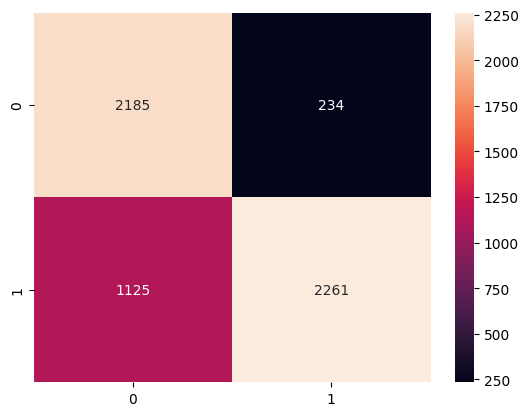

In [ ]:
 # Conf Matrix
 sns_matrix_BART_app = sns.heatmap(confusion_matrix_Appraisal_Bart, annot= True, fmt='g')

In [ ]:
sns_matrix_BART_app

<Axes: >

In [ ]:
sns_matrix_BART_app.figure.savefig("Conf_mat_App_BART_ZSC.png")

### SetFit with RoBERTa (sentence-transformers/all-roberta-large-v1)

In [ ]:
model_roberta = SetFitModel.from_pretrained("sentence-transformers/all-roberta-large-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    batch_size=16,
    num_epochs=5,# Number of epochs to use for contrastive learning
)

In [ ]:
model_roberta.lables = ['yes', 'no']

In [ ]:
# Creating the trainer
trainer_rob = SetFitTrainer(
    model=model_roberta,
    train_dataset=training_data,
    eval_dataset=test_data,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=5, # Number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"}
)

<ipython-input-18-05fc442af50e>:2: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer_rob = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/645 [00:00<?, ? examples/s]

In [ ]:
# Training
trainer_rob.train()

***** Running training *****
  Num unique pairs = 25800
  Batch size = 16
  Num epochs = 5
  Total optimization steps = 8065


Step,Training Loss


In [ ]:
trainer_rob.evaluate(test_data)

Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'accuracy': 0.7434969853574505}

#### Prediction of Appraisal Labels

In [ ]:
# Predicting labels for test data 10 speeches annotated
predicted_Appraisal_Rob = model_roberta.predict(test_data_df['text'])

In [ ]:
 # Adding column with predicted labels to original test dataset
test_data_df['SetFit-RoBERTa Appraisal Predicted']=pd.Series(predicted_Appraisal_Rob)

In [ ]:
test_data_df

,Annotated Text,Label,matches,text,label,SetFit-RoBERTa Appraisal Predicted
0,wishes to express its satisfaction,affect-positive,Uruguay wishes to express its satisfaction for...,Uruguay wishes to express its satisfaction for...,yes,yes
1,NaN,NaN,None,(2016).,no,no
2,we want to thank,affect-positive,"At the outset, we want to thank the United Sta...","At the outset, we want to thank the United Sta...",yes,yes
3,is very pleased,affect-positive,Uruguay is very pleased to join the rest of th...,Uruguay is very pleased to join the rest of th...,yes,yes
4,problem,appreciation-negative,that dealing with this problem can no longer b...,that dealing with this problem can no longer b...,yes,yes
...,...,...,...,...,...,...
5800,is not even the most radical group,judgement-negative,And that is not even the most radical group on...,And that is not even the most radical group on...,yes,yes
5801,peaceful political protects,appreciation-positive,Should we be surprised that the peaceful polit...,Should we be surprised that the peaceful polit...,yes,yes
5802,NaN,NaN,None,and the call by the people of south-eastern Uk...,no,no
5803,NaN,NaN,None,have been met by the Rada with draconic laws,no,no


In [ ]:
test_data_df['SetFit-RoBERTa Appraisal Predicted'].value_counts()

yes    3640
no     2165
Name: SetFit-RoBERTa Appraisal Predicted, dtype: int64

In [ ]:
# Saving predictions
test_data_df.to_csv("Results predictions Appraisal SetFit-RoBERTa .csv")

#### Evaluation

In [ ]:
# Calculating accuracy-
accuracy_app_Rob = accuracy_score(predicted_Appraisal_Rob, gold_labels_appraisal)
print("Accuracy score: {:.2f}".format(accuracy_app_Rob*100))


Accuracy score: 74.35


In [ ]:
# Classification Report - INTERPRET THIS RESULTS
# y_true, y_pred, labels= xxx
print(classification_report(gold_labels_appraisal, predicted_Appraisal_Rob))

              precision    recall  f1-score   support

          no       0.94      0.60      0.73      3386
         yes       0.63      0.94      0.75      2419

    accuracy                           0.74      5805
   macro avg       0.78      0.77      0.74      5805
weighted avg       0.81      0.74      0.74      5805



In [ ]:
# Confusion Matrix
# y_true, y_pred, labels= xxx
confusion_matrix_Appraisal_Rob = confusion_matrix(gold_labels_appraisal, predicted_Appraisal_Rob, labels=appraisal_labels)

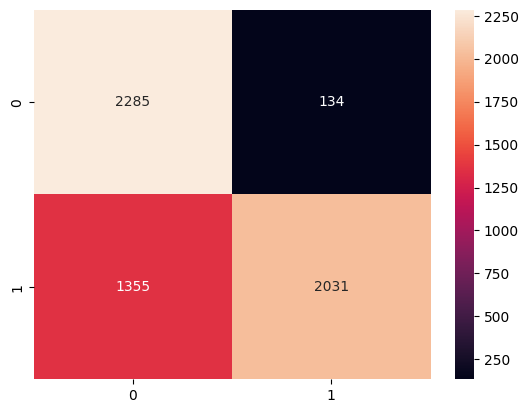

In [ ]:
# Conf Matrix
sns_matrix_Rob_app = sns.heatmap(confusion_matrix_Appraisal_Rob, annot= True, fmt='g')

In [ ]:
sns_matrix_Rob_app.figure.savefig("Conf_mat_App_SentTrans_RoBERTa.png")

### SetFit with T5 (sentence-transformers/sentence-t5-base)

In [ ]:
model_t5 = SetFitModel.from_pretrained("sentence-transformers/sentence-t5-base")

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    batch_size=16,
    num_epochs=5,# Number of epochs to use for contrastive learning
)

In [ ]:
model_t5.lables = ['yes', 'no']

In [ ]:
# Creating the trainer
trainer = SetFitTrainer(
    model=model_t5,
    train_dataset=training_data,
    eval_dataset=test_data,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1, # Number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"}
)

<ipython-input-34-f27be139d571>:2: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/645 [00:00<?, ? examples/s]

In [ ]:
# Training
trainer.train()

***** Running training *****
  Num unique pairs = 25800
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1613


Step,Training Loss


In [ ]:
trainer.evaluate(test_data)

Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'accuracy': 0.7381567614125754}

#### Aprraisal Label Predictions

In [ ]:
# Predicting labels for test data
predicted_Appraisal_T5 = model_t5.predict(test_data_df['text'])

In [ ]:
 # Adding column with predicted labels to original test dataset
test_data_df['Results Apparaisal SetFit-T5']=pd.Series(predicted_Appraisal_T5)

In [ ]:
test_data_df['Results Apparaisal SetFit-T5'].value_counts()

no     2982
yes    2823
Name: Results Apparaisal SetFit-T5, dtype: int64

In [ ]:
test_data_df

,Annotated Text,Label,matches,text,label,SetFit-RoBERTa Appraisal Predicted,Results Apparaisal SetFit-T5
0,wishes to express its satisfaction,affect-positive,Uruguay wishes to express its satisfaction for...,Uruguay wishes to express its satisfaction for...,yes,yes,no
1,NaN,NaN,None,(2016).,no,no,no
2,we want to thank,affect-positive,"At the outset, we want to thank the United Sta...","At the outset, we want to thank the United Sta...",yes,yes,yes
3,is very pleased,affect-positive,Uruguay is very pleased to join the rest of th...,Uruguay is very pleased to join the rest of th...,yes,yes,no
4,problem,appreciation-negative,that dealing with this problem can no longer b...,that dealing with this problem can no longer b...,yes,yes,yes
...,...,...,...,...,...,...,...
5800,is not even the most radical group,judgement-negative,And that is not even the most radical group on...,And that is not even the most radical group on...,yes,yes,yes
5801,peaceful political protects,appreciation-positive,Should we be surprised that the peaceful polit...,Should we be surprised that the peaceful polit...,yes,yes,no
5802,NaN,NaN,None,and the call by the people of south-eastern Uk...,no,no,no
5803,NaN,NaN,None,have been met by the Rada with draconic laws,no,no,no


In [ ]:
# Saving predictions
test_data_df.to_csv("Results Appraisal SetFit-T5.csv")

#### Evaluation

In [ ]:
# Calculating accuracy-
accuracy_app_T5 = accuracy_score(predicted_Appraisal_T5, gold_labels_appraisal)
print("Accuracy score: {:.2f}".format(accuracy_app_T5*100))

Accuracy score: 73.82


In [ ]:
# Classification Report - INTERPRET THIS RESULTS
# y_true, y_pred, labels= xxx
print(classification_report(gold_labels_appraisal, predicted_Appraisal_T5))

              precision    recall  f1-score   support

          no       0.81      0.72      0.76      3386
         yes       0.66      0.77      0.71      2419

    accuracy                           0.74      5805
   macro avg       0.74      0.74      0.74      5805
weighted avg       0.75      0.74      0.74      5805



In [ ]:
# Confusion Matrix
# y_true, y_pred, labels= xxx
confusion_matrix_Appraisal_T5 = confusion_matrix(gold_labels_appraisal, predicted_Appraisal_T5, labels=appraisal_labels)

In [ ]:
confusion_matrix_Appraisal_T5

array([[1861,  558],
       [ 962, 2424]])

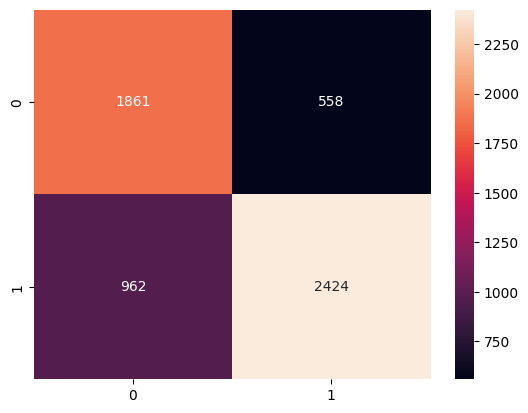

In [ ]:
# Conf Matrix
sns_matrix_t5_app = sns.heatmap(confusion_matrix_Appraisal_T5, annot= True, fmt='g')

In [ ]:
sns_matrix_t5_app.figure.savefig("Conf_mat_App_SentTrans_T5.png")